# Assignment 2

Written by Zitong Li for COMP9418

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from graphviz import Digraph
import numpy as np
import pandas as pd
import copy as cp
from collections import OrderedDict as odict
from itertools import product, combinations
from tabulate import tabulate

In [2]:
from assigment2 import GraphicalModel, JoinTree

## Representation

### 1. Insert and remove nodes.

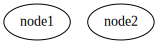

In [3]:
g = GraphicalModel()
g.insert('node1', ('yes', 'no'))
g.insert('node2', ('yes', 'no'))

g.showGraph()

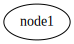

In [4]:
g.remove('node2')
g.showGraph()

### 2. Connect and disconnect nodes with edges.

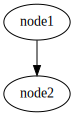

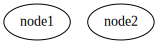

In [5]:
g.insert('node2', ('yes', 'no'))
g.connect('node1', 'node2')
g.showGraph()
g.disconnect('node1', 'node2')
g.showGraph()

### 3. Specify probabilities for a node.

In [6]:
g.connect('node1', 'node2')
g.factorize('node1', [0.1, 0.9])
print(g.factors)
print('node1:')
g.printFactor('node1')
g.factorize('node2', [0.5, 0.5, 0.3, 0.7], ['node1'])
print('node2:')
g.printFactor('node2')

{'node1': {'dom': ('node1',), 'table': OrderedDict([(('yes',), 0.1), (('no',), 0.9)])}}
node1:
| node1   |   Pr |
|---------+------|
| yes     |  0.1 |
| no      |  0.9 |
node2:
| node1   | node2   |   Pr |
|---------+---------+------|
| yes     | yes     |  0.5 |
| yes     | no      |  0.5 |
| no      | yes     |  0.3 |
| no      | no      |  0.7 |


### 4. Save Bayesian network to a file.

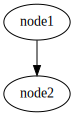

In [7]:
g.save('save_test.net')
g.load('save_test.net')
g.showGraph()

### 5. Load from .net file.

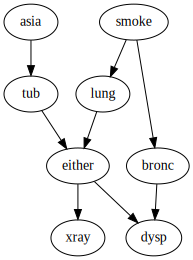

| smoke   | lung   |   Pr |
|---------+--------+------|
| yes     | yes    | 0.1  |
| yes     | no     | 0.9  |
| no      | yes    | 0.01 |
| no      | no     | 0.99 |


In [8]:
g = GraphicalModel()
g.load('small/asia.net')
g.showGraph()
g.printFactor('lung')

## Pruning and pre-processing techniques for inference

The point of prunning is to find the smallest subgraph of a Bayesian Network that will correctly compute the conditional distribution of a subset of variables in it.

### 1. Network pruning techniques based on query structure.
Suppose our query is P(Q|K), we can prune the network by removing all nodes that are d-seperated from Q by K, and than recursively prune the leaf node that is not in Q $\cup$ K

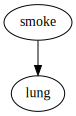

| smoke   | lung   |   Pr |
|---------+--------+------|
| yes     | yes    | 0.1  |
| yes     | no     | 0.9  |
| no      | yes    | 0.01 |
| no      | no     | 0.99 |


In [9]:
pruned_graph = g.prune(['lung'])
pruned_graph.showGraph()
pruned_graph.printFactor('lung')

### 2. Min-fill heuristic for variable order elimination. 

   Deterministic and stochastic composition of min-fill heuristic with min-degree heuristic.
   
   We decide to use **min-fill to select node** and **broke ties stochastically**.

**1. moralize the graph**

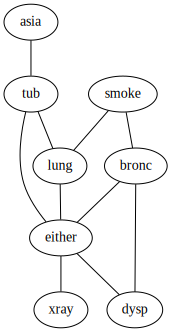

In [10]:
g.show_moral_graph()

**2. eliminate variables based on the Min-fill heuristic.**

Choose the node with smallest fill-in edge num, if fill-in edge num are same, choose the one with smaller degree.

In [11]:
ve_order, width = g.min_fill_order()
ve_order
width

['asia', 'xray', 'tub', 'dysp', 'smoke', 'lung', 'bronc', 'either']

2

## Benchmark

In [12]:
import time

datas = """small/asia.net,
medium/alarm.net,
large/win95pts.net,
very_large/andes.net,
massive/munin.net"""

min_fill = []
min_degree = []
mf_time = []
md_time = []
for file in datas.split(',\n'):
    g = GraphicalModel()
    g.load(file)
    s = time.time()
    min_fill_order, min_fill_width = g.min_fill_order()
    min_fill_time = time.time() - s
    
    s = time.time()
    min_degree_order, min_degree_width = g.min_degree_order()
    min_degree_time = time.time() - s
    
    min_fill.append(min_fill_width)
    min_degree.append(min_degree_width)
    mf_time.append(min_fill_time)
    md_time.append(min_degree_time)
    print(file + ' done')



small/asia.net done
medium/alarm.net done
large/win95pts.net done
very_large/andes.net done
massive/munin.net done


1. Compare the width of min fill and min degree.

In [13]:
import matplotlib.pyplot as plt
InteractiveShell.ast_node_interactivity = "last_expr"

name_list = ['small', 'medium', 'large', 'very large', 'massive']

x =list(range(len(name_list)))
total_width, n = 0.8, 2
width = total_width / n

plt.figure(figsize=(10,5), dpi=150)
a = plt.bar(x, min_fill, width=width, label='min fill')
for i in range(len(x)):
    x[i] += width
b = plt.bar(x, min_degree, width=width, label='min degree',tick_label = name_list)
plt.xlabel('network size')
plt.ylabel('width')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/3, height, '%.4s' % float(height))

autolabel(a)
autolabel(b)

plt.legend()
plt.show()

<Figure size 1500x750 with 0 Axes>

Text(0.5, 0, 'network size')

Text(0, 0.5, 'width')

<Figure size 1500x750 with 1 Axes>

2. Compare the time cost of min fill and min degree.

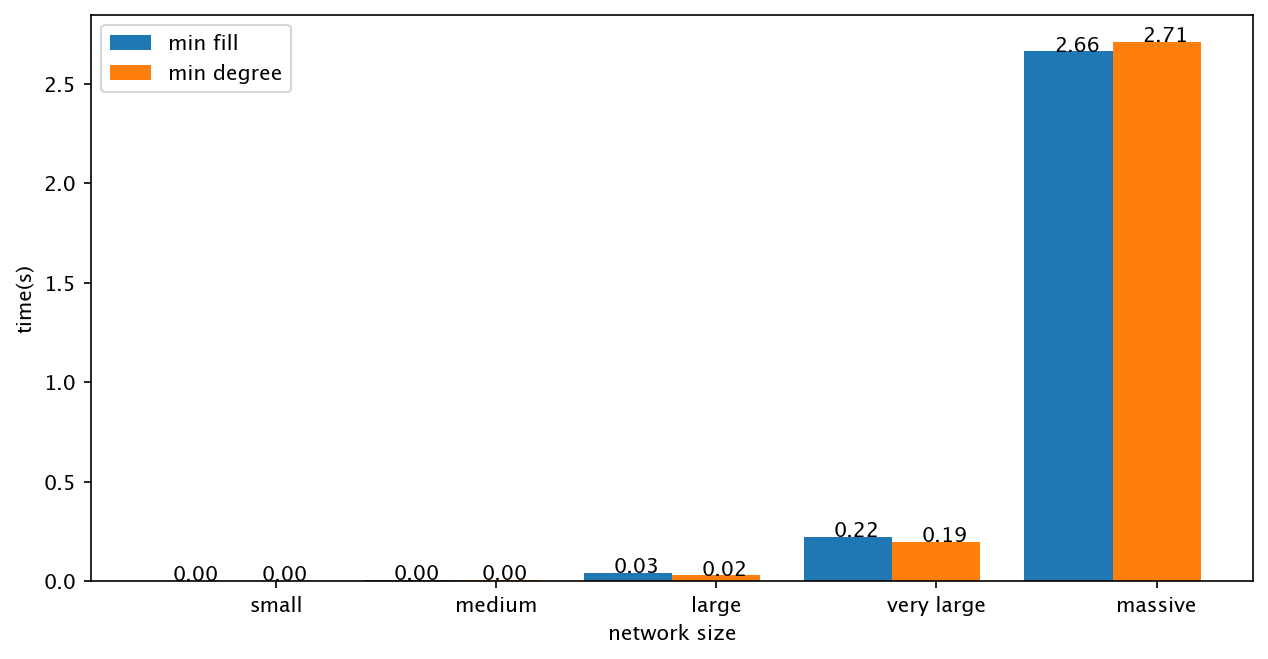

In [14]:
x =list(range(len(name_list)))
total_width, n = 0.8, 2
width = total_width / n

plt.figure(figsize=(10,5), dpi=150)
a = plt.bar(x, mf_time, width=width, label='min fill')
for i in range(len(x)):
    x[i] = x[i] + width
b = plt.bar(x, md_time, width=width, label='min degree',tick_label = name_list)

autolabel(a)
autolabel(b)
plt.xlabel('network size')
plt.ylabel('time(s)')

plt.legend()
plt.show()

## Exact inference

1. A representation for the jointree that can be specified by the user
2. A function that converts an elimination order into a jointree


moral graph:
jointree:


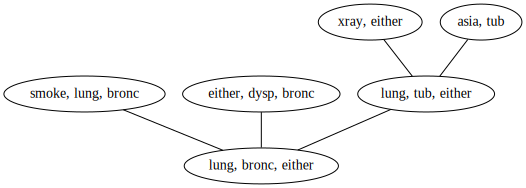

In [15]:
InteractiveShell.ast_node_interactivity = "all"

g = GraphicalModel()
g.load('small/asia.net')
moral_graph = g.moralize()
print('moral graph:')
g.show_moral_graph()
jointree = moral_graph.to_jointree(ve_order)
print('jointree:')
jointree.show_jointree()

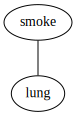

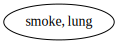

In [16]:
pruned_graph = g.prune(['lung'])
moral_pruned_graph = pruned_graph.moralize()
pruned_graph.show_moral_graph()
pruned_ve_order, width = pruned_graph.min_fill_order()
pruned_jointree = moral_pruned_graph.to_jointree(pruned_ve_order)
pruned_jointree.show_jointree()

3. A function to set evidence

    The evidence value has already been set at the prunning step.

4. A function to answer a query based on the jointree clusters

In [17]:
answer = pruned_jointree.queryCluster(['lung'])
pruned_jointree.printFactor(answer)

| lung   |    Pr |
|--------+-------|
| yes    | 0.055 |
| no     | 0.945 |


### JoinTree functions

1. add a cluster


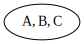

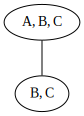

In [18]:
jt = JoinTree()
jt.add_cluster(('A', 'B', 'C'))
jt.show_jointree()
jt.add_cluster(('B', 'C'), next_to=('A', 'B', 'C'))
jt.show_jointree()

2. remove a cluster


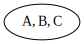

In [19]:
jt.remove(('B', 'C'))
jt.show_jointree()

3. add a variable


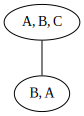

In [20]:
jt.add_cluster(('B'), next_to=('A', 'B', 'C'))
jt.add_var('A', ('B'))
jt.show_jointree()

4. merge two cluster


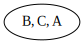

In [21]:
jt.merge(('A','B','C'), ('B', 'A'))
jt.show_jointree()

## Approximate inference

### Gibbs sampling
#### 1. A function that let the user specify the number of chains.
    
   See as `burn_in()` in the class.

In [22]:
chains = g.burn_in(chain_num=5)
for chain in chains:
    print(chain.node_value)

{'asia': 'no', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'yes', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'no', 'tub': 'no', 'smoke': 'no', 'lung': 'no', 'bronc': 'no', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'no', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'no'}
{'asia': 'no', 'tub': 'no', 'smoke': 'yes', 'lung': 'no', 'bronc': 'yes', 'either': 'no', 'xray': 'no', 'dysp': 'yes'}


#### 2. A function to mix up chains until convergence.

   See as `burn_in()` in the class. The output of this function are already mixed up chains.
    
    

#### 3. A function that samples the chains for a specified number of samples.

   See as `gibbs_sampling()` in the class.

In [23]:
samples = g.gibbs_sampling(sample_num=1000, chain_num=3, q_vars=['asia'], either='yes')

In [24]:
samplesdf = pd.DataFrame(samples)
samplesdf.describe()

,asia
count,1000
unique,2
top,no
freq,993


#### 4. A function to answer queries based on the samples.

   See as `answer_from_samples()` in the class.

In [25]:
answer = g.answer_from_samples(samples)
answer.to_dict('records')

[{'asia': 'yes', 'prob': 0.007}, {'asia': 'no', 'prob': 0.993}]

In [26]:
g.printFactor('asia')

| asia   |   Pr |
|--------+------|
| yes    | 0.01 |
| no     | 0.99 |


Compared to the CPT, the sampling answer is quite accurate.

## Accuracy benchmark

pick one of the variables in the network as query each time, compare the exact inference result and sampling result.

In [27]:
def get_accuracy(network):
    g = GraphicalModel()
    g.load(network)
    accuracy = []
    for var in g.net.keys():
        pruned_g = g.prune([var])
        moral_pruned_g = pruned_g.moralize()
        pruned_ve_order, width = pruned_g.min_fill_order()
        pruned_jointree = moral_pruned_g.to_jointree(pruned_ve_order)
        # exact answer
        exact_answer = pruned_jointree.queryCluster([var])
        # sampling answer
        samples = g.gibbs_sampling(q_vars=[var])
        sample_answer = g.answer_from_samples(samples)
        score = compare(exact_answer, sample_answer)
        accuracy.append(score)
    return np.mean(accuracy)

def compare(exact, sample_answer):
    var = sample_answer.columns[0]
    s_records = sample_answer.to_dict('records')
    n = len(s_records)
    s = 0
    for record in s_records:
        outcome = record[var]
        s_prob = record['prob']
        e_prob = exact['table'][(outcome,)]
        diff = abs(s_prob - e_prob)
        s += diff
        
    return 1 - s/n

In [30]:
get_accuracy('small/asia.net')

0.9307379289600672

In [28]:
get_accuracy('medium/alarm.net')

0.8897851746651924

In [31]:
get_accuracy('large/win95pts.net')

0.8797842836795763

  Cannot get accuracy of networks with size over very large, because we can't get an exact inference in feasible time.